This notebook presents a positional comparison of timing and Gaia+VLBI astrometric solutions, assuming that the misalignment between Gaia and VLBI celestial frames is much smaller than those between timing and Gaia or VLBI frames.

In all, I consider DE200, DE405, DE421, DE430, and DE436 in this notebook.

- Remove two pulsars (PSR J1435-6100 and PSR J1955+2908) that are most likely not ture associations for the Gaia pulsar sample and one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the Gaia EDR3.

- Remove all data points with offset greater than 1 arcsec in the absolute sense in either RA or Dec. Such a discrepancy is unlikely linked to the frame mis-alignment. **(2022-05-05)** 

- Remove PSRs near the Ecliptic plane, i.e., the ecliptic latitude is within $\pm\,5\,^{\circ}$. **(2022-06-10)** 

- Fix a serious bug in computing the RA offset and its uncertainty **(2022-08-13)**

In [1]:
from functools import reduce

import numpy as np
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join, vstack
from astropy.time import Time
from matplotlib import pyplot as plt
from psrcrf_tools import *
from statsmodels.iolib.table import SimpleTable

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

Prepare the data for further analyses.

## 1.1 Load the database


### A) Gaia and timing solutions

Read the timing solution data.

In [2]:
timing_table = Table.read(
    "../data/timing_edr3.fits",
)
timing_table.sort("psr_name")

Remove two pulsars (PSR J1435-6100 and PSR J1955+2908) that are most likely not ture associations and one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the *Gaia* EDR3.

In [3]:
mask = (
    (timing_table["psr_name"] != "J1435-6100")
    & (timing_table["psr_name"] != "J1955+2908")
    & (timing_table["psr_name"] != "J1546-5302")
)
timing_table = Table(timing_table[mask], masked=False)

Add unit information

In [4]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [5]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")

Only keep the astrometric parameters from Gaia.

In [6]:
edr3_antf_table = edr3_antf_table[
    "name",
    "source_id",
    "ra",
    "ra_error",
    "dec",
    "dec_error",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
]

edr3_antf_table.rename_columns(
    [
        "name",
        "ra_error",
        "dec_error",
        "parallax",
        "parallax_error",
        "pmra_error",
        "pmdec_error",
    ],
    ["psr_name", "ra_err", "dec_err", "plx", "plx_err", "pmra_err", "pmdec_err"],
)

Add unit information

In [7]:
edr3_antf_table["ra"].unit = u.deg
edr3_antf_table["dec"].unit = u.deg
edr3_antf_table["pmra"].unit = u.mas / u.yr
edr3_antf_table["pmdec"].unit = u.mas / u.yr
edr3_antf_table["plx"].unit = u.mas
edr3_antf_table["ra_err"].unit = u.mas
edr3_antf_table["dec_err"].unit = u.mas
edr3_antf_table["pmra_err"].unit = u.mas / u.yr
edr3_antf_table["pmdec_err"].unit = u.mas / u.yr
edr3_antf_table["plx_err"].unit = u.mas

Supplement the timing table with the Gaia astrometric information.

In [8]:
edr3_timing = join(
    timing_table,
    edr3_antf_table,
    keys="psr_name",
    join_type="left",
    table_names=["t", "g"],
)

# count_psr_nb(edr3_timing)

### B) VLBI and timing solutions

Read the timing solution data.

In [9]:
timing_table = Table.read(
    "../data/timing_vlbi.fits",
)

timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load PSRPI solution.

In [10]:
vlbi_table = Table.read("../data/psrpi.dat", format="ascii")

vlbi_table["ra"].unit = u.deg
vlbi_table["dec"].unit = u.deg
vlbi_table["pmra"].unit = u.mas / u.yr
vlbi_table["pmdec"].unit = u.mas / u.yr
vlbi_table["plx"].unit = u.mas
vlbi_table["ra_err"].unit = u.mas
vlbi_table["dec_err"].unit = u.mas
vlbi_table["pmra_err"].unit = u.mas / u.yr
vlbi_table["pmdec_err"].unit = u.mas / u.yr
vlbi_table["plx_err"].unit = u.mas

Join these two solutions.

In [11]:
vlbi_timing = join(
    timing_table, vlbi_table, keys="psr_name", join_type="left", table_names=["t", "g"]
)

vlbi_timing.rename_column("pos_epoch_t", "pos_epoch")

# count_psr_nb(vlbi_timing)

## 1.2 Compute offsets between pulsar positions from timing and Gaia

Propagate the Gaia EDR3 position from J2016.0 to the timing positonal epoch and compute the positional offset,
in the sense of timing minus Gaia.

In [12]:
gaia_epoch = Time("2016.0", format="jyear").mjd
# 57388.5

# Epoch difference in Julian year
dt_y = (edr3_timing["pos_epoch"].value - gaia_epoch) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(edr3_timing["dec_g"].value))

dra = (
    edr3_timing["ra_t"] - edr3_timing["ra_g"]
) * dec_fac - dt_y * edr3_timing["pmra_g"]

ddec = edr3_timing["dec_t"] - edr3_timing["dec_g"] - \
    dt_y * edr3_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

edr3_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [13]:
edr3_timing["ra_err_t"] = edr3_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    edr3_timing["ra_err_g"] ** 2
    + edr3_timing["ra_err_t"] ** 2
    + (dt_y * edr3_timing["pmra_err_g"]).value ** 2
)

ddec_err = np.sqrt(
    edr3_timing["dec_err_g"] ** 2
    + edr3_timing["dec_err_t"] ** 2
    + (dt_y * edr3_timing["pmdec_err_g"]).value ** 2
)

edr3_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

Propagate the VLBI position from its epoch to the timing positonal epoch and compute the positional offset,
in the sense of timing minus VLBI.

In [14]:
# Epoch difference in Julian year
dt_y = (vlbi_timing["pos_epoch"].value -
        vlbi_timing["pos_epoch_g"]) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(vlbi_timing["dec_g"].value))

dra = (
    vlbi_timing["ra_t"] - vlbi_timing["ra_g"]
) * dec_fac - dt_y * vlbi_timing["pmra_g"]

ddec = vlbi_timing["dec_t"] - vlbi_timing["dec_g"] - \
    dt_y * vlbi_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

vlbi_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [15]:
vlbi_timing["ra_err_t"] = vlbi_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    vlbi_timing["ra_err_g"] ** 2
    + vlbi_timing["ra_err_t"] ** 2
    + (dt_y * vlbi_timing["pmra_err_g"]).value ** 2
)

ddec_err = np.sqrt(
    vlbi_timing["dec_err_g"] ** 2
    + vlbi_timing["dec_err_t"] ** 2
    + (dt_y * vlbi_timing["pmdec_err_g"]).value ** 2
)

vlbi_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

Join the Gaia-timing and VLBI-timing tables.

In [16]:
gv_timing = vstack((edr3_timing, vlbi_timing))

In [17]:
count_psr_nb(gv_timing)

There are 90 pulsars with 280 measurements.


## 1.3 Plot the sky distribution

Find pulsars according to the underlying reference frames the time positions are referring to.

In [18]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

mask = gv_timing["eph"] == "DE436"
gv_timing436 = gv_timing[mask]

I plot the distribution for all pulsars in one figure.

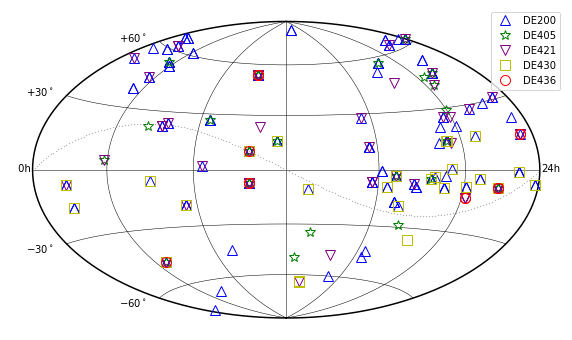

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, "$+%d^\circ$" % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, "$-%d^\circ$" % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(gv_timing200["ra_g"], gv_timing200["dec_g"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(gv_timing405["ra_g"], gv_timing405["dec_g"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(gv_timing421["ra_g"], gv_timing421["dec_g"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(gv_timing430["ra_g"], gv_timing430["dec_g"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(gv_timing436["ra_g"], gv_timing436["dec_g"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

# Ecliptic plane
lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

## 1.4 Compute statistics of position formal uncertainties

Compute the median positional formal uncertainties for each subset.

In [20]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((5, 6))

pos_err_tab[0, :] = calc_med_pos_err(gv_timing200)
pos_err_tab[1, :] = calc_med_pos_err(gv_timing405)
pos_err_tab[2, :] = calc_med_pos_err(gv_timing421)
pos_err_tab[3, :] = calc_med_pos_err(gv_timing430)
pos_err_tab[4, :] = calc_med_pos_err(gv_timing436)

# 2 Compare timing and Gaia+VLBI positions

##  2.1 DE200 vs Gaia EDR3 + PSRpi

In [21]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

nb_psr_200 = len(gv_timing200.group_by("psr_name").groups)
nb_obs_200 = len(gv_timing200)

print("We have", nb_psr_200,
      "pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_200, "observations.")
# gv_timing200

We have 72 pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with 140 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


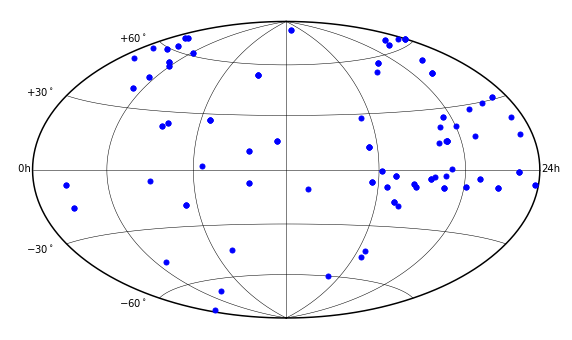

In [22]:
sou_dist_plot(
    gv_timing200["ra_g"],
    gv_timing200["dec_g"])

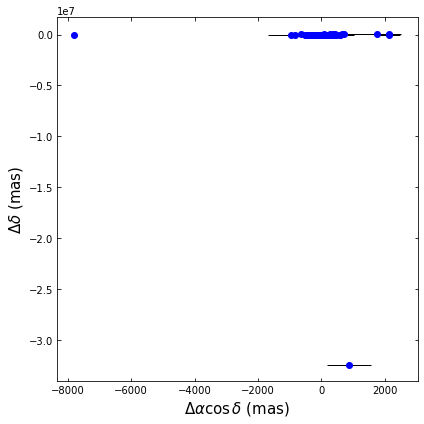

In [23]:
simple_plot(gv_timing200)

First, we check the positional offset visually.

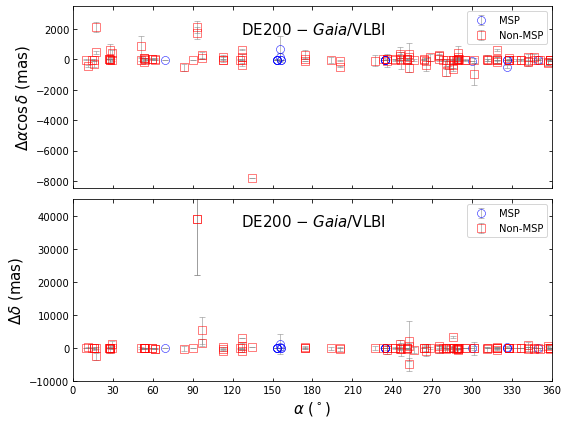

In [24]:
pos_oft_vs_coord(
    gv_timing200,
    [-8500, 3500, -10000, 45000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="ra",
    divided=True)

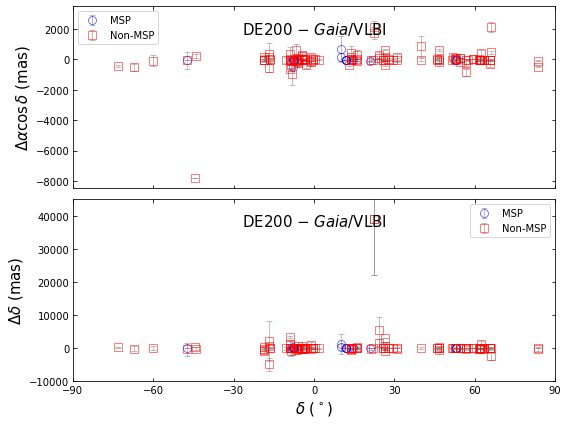

In [25]:
val_max = 1000
pos_oft_vs_coord(
    gv_timing200,
    [-8500, 3500, -10000, 45000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="dec",
    divided=True)

Change the limits of the X- and Y-axes to remove the extremely large offsets. 

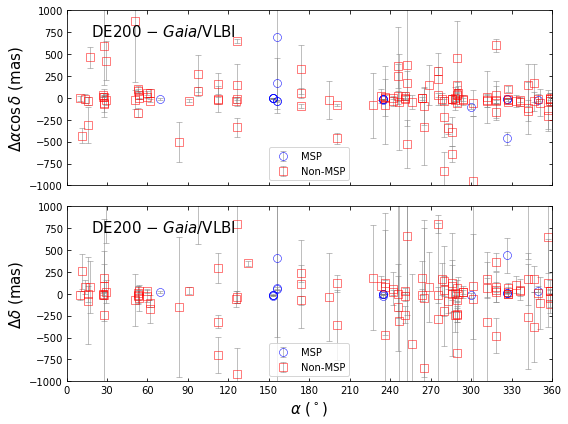

In [26]:
pos_oft_vs_coord(
    gv_timing200,
    [-1000, 1000, -1000, 1000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="ra",
    divided=True)

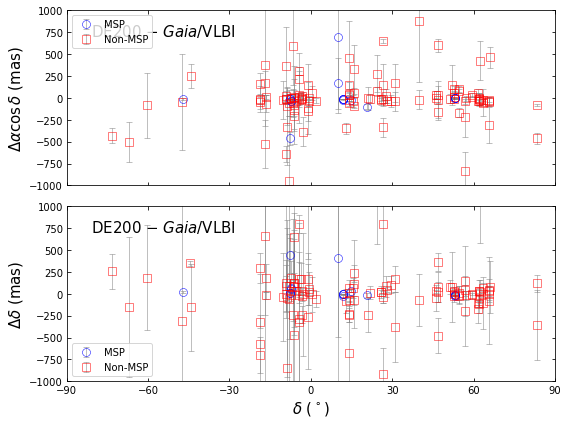

In [27]:
val_max = 1000
pos_oft_vs_coord(
    gv_timing200,
    [-1000, 1000, -1000, 1000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="dec",
    divided=True)

## 2.2 DE405 vs Gaia EDR3

In [28]:
mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

nb_psr_405 = len(gv_timing405.group_by("psr_name").groups)
nb_obs_405 = len(gv_timing405)

print("We have", nb_psr_405,
      "pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_405, "observations.")

# gv_timing405

We have 22 pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with 26 observations.


Plot the sky distribution.

/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


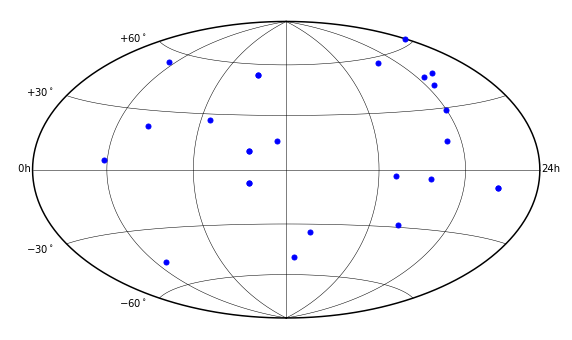

In [29]:
sou_dist_plot(gv_timing405["ra_g"], gv_timing405["dec_g"])

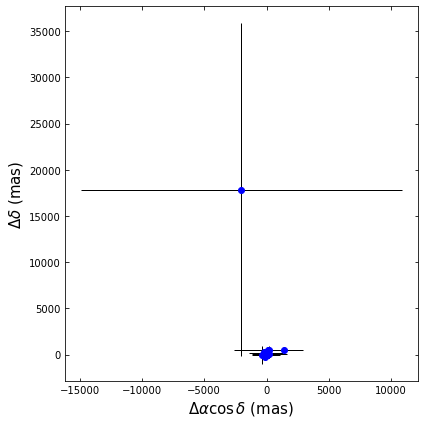

In [30]:
simple_plot(gv_timing405)

Plot the relationship between position offsets and RA/DEC.

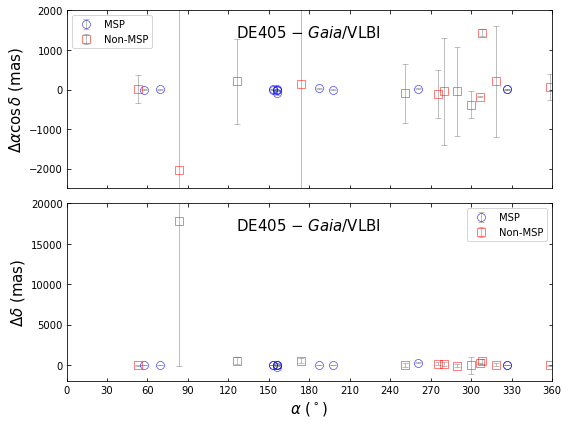

In [31]:
pos_oft_vs_coord(gv_timing405, [-2500, 2000, -2000, 20000],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 ref="g",
                 xaxis="ra",
                 add_text=[0.35, 0.85, "DE405 $-$ $Gaia$/VLBI"],
                 divided=True)

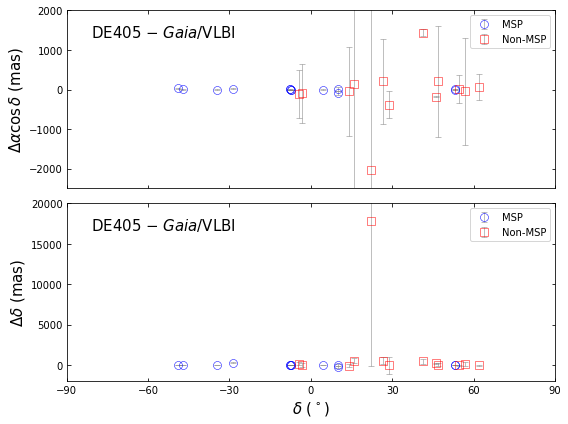

In [32]:
pos_oft_vs_coord(gv_timing405, [-2500, 2000, -2000, 20000],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE405 $-$ $Gaia$/VLBI"],
                 divided=True)

Change the limits of the X- and Y- axes.

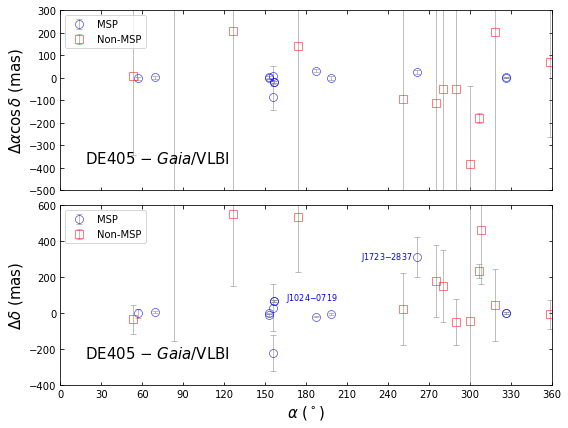

In [33]:
pos_oft_vs_coord(gv_timing405, [-500, 300, -400, 600],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 add_text=[0.05, 0.15, "DE405 $-$ $Gaia$/VLBI"],
                 add_text_msp=[[220, 300, "J1723$-$2837", 1],
                               [165, 70, "J1024$-$0719", 1]],
                 ref="g",
                 xaxis="ra",
                 divided=True)

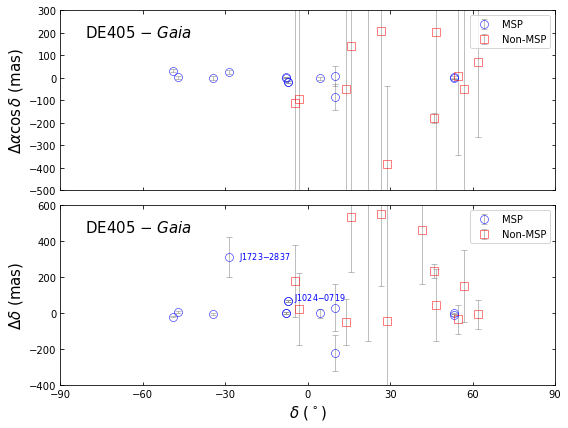

In [34]:
pos_oft_vs_coord(gv_timing405, [-500, 300, -400, 600],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE405 $-$ $Gaia$"],
                 add_text_msp=[[-25, 300, "J1723$-$2837", 1],
                               [-5, 70, "J1024$-$0719", 1]],
                 divided=True)

## 2.3 DE421 vs Gaia EDR3

In [35]:
mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

nb_psr_421 = len(gv_timing421.group_by("psr_name").groups)
nb_obs_421 = len(gv_timing421)

print("We have", nb_psr_421,
      "pulsars in the sample from DE421 vs. Gaia DR3 comparison with",
      nb_obs_421, "observations.")

We have 34 pulsars in the sample from DE421 vs. Gaia DR3 comparison with 55 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


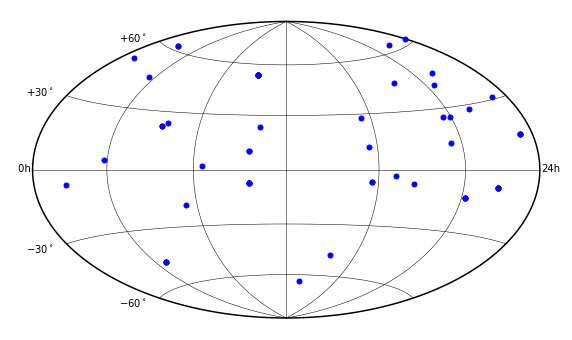

In [36]:
sou_dist_plot(gv_timing421["ra_g"], gv_timing421["dec_g"])

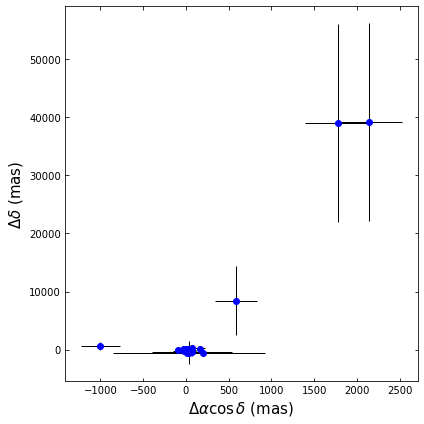

In [37]:
simple_plot(gv_timing421)

Obviously, there is one measurment is far from the other points.

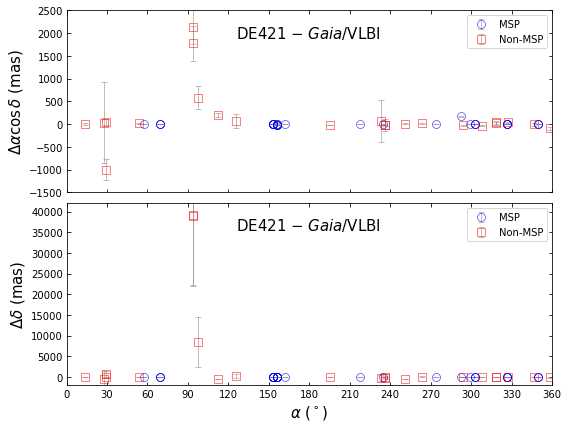

In [38]:
pos_oft_vs_coord(gv_timing421, [-1500, 2500, -2000, 42000],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 add_text=[0.35, 0.85, "DE421 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

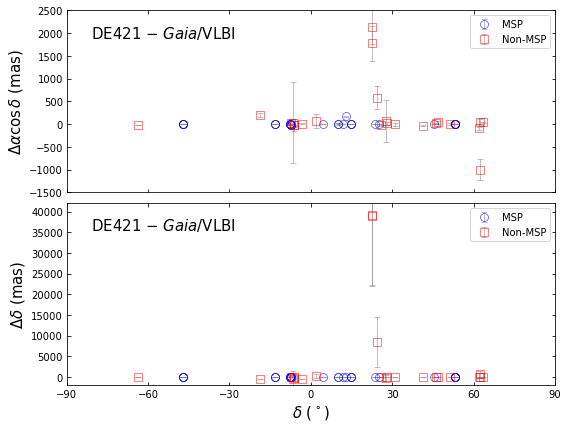

In [39]:
pos_oft_vs_coord(gv_timing421, [-1500, 2500, -2000, 42000],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE421 $-$ $Gaia$/VLBI"],
                 divided=True)

Shorten the limits of the X- and Y- axes.

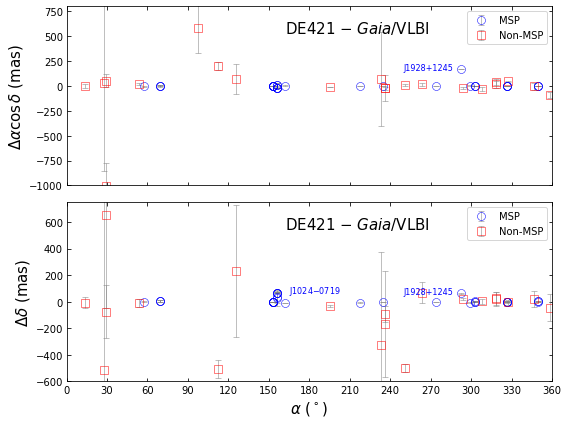

In [40]:
pos_oft_vs_coord(gv_timing421, [-1000, 800, -600, 750],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 add_text=[0.45, 0.85, "DE421 $-$ $Gaia$/VLBI"],
                 add_text_msp=[[250, 160, "J1928+1245", 0],
                               [165, 65, "J1024$-$0719", 1],
                               [250, 60, "J1928+1245", 1]],
                 ref="g",
                 xaxis="ra",
                 divided=True)

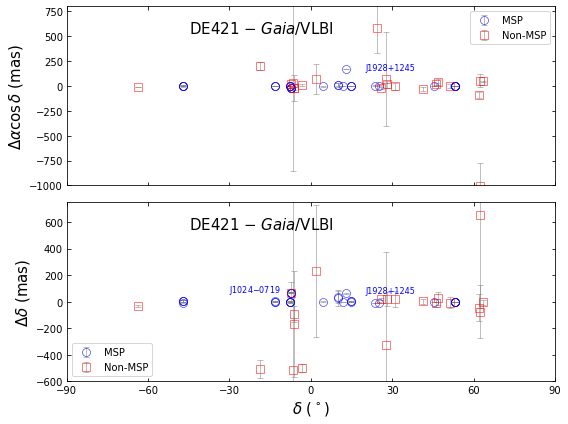

In [41]:
pos_oft_vs_coord(gv_timing421, [-1000, 800, -600, 750],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.25, 0.85, "DE421 $-$ $Gaia$/VLBI"],
                 add_text_msp=[[20, 160, "J1928+1245", 0],
                               [-30, 70, "J1024$-$0719", 1],
                               [20, 65, "J1928+1245", 1]],
                 divided=True)

## 2.4 DE430 vs Gaia EDR3

In [42]:
mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

nb_psr_430 = len(gv_timing430.group_by("psr_name").groups)
nb_obs_430 = len(gv_timing430)

# count_psr_nb(gv_timing430)
print("We have", nb_psr_430,
      "pulsars in the sample from DE430 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_430, "observations.")
# edr3_timing430

We have 26 pulsars in the sample from DE430 vs. Gaia DR3 + PSRpi comparison with 41 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


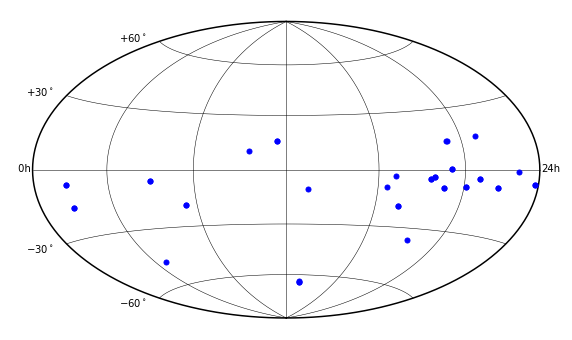

In [43]:
sou_dist_plot(
    gv_timing430["ra_g"],
    gv_timing430["dec_g"],
)

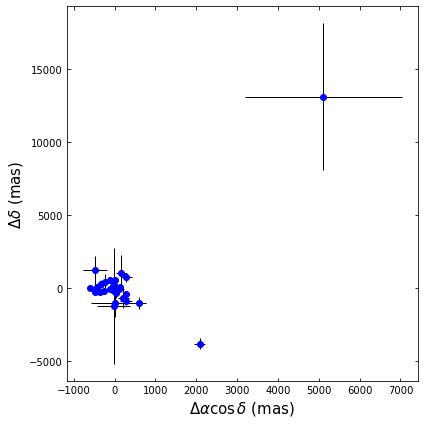

In [44]:
simple_plot(gv_timing430)

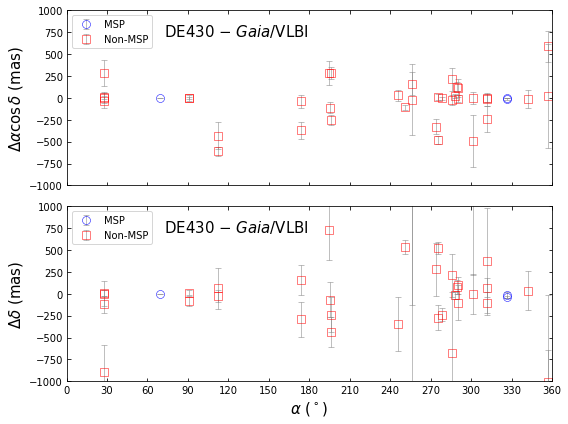

In [45]:
pos_oft_vs_coord(gv_timing430, [-1000, 1000, -1000, 1000],
                 gv_timing430["dra"],
                 gv_timing430["ddec"],
                 add_text=[0.2, 0.85, "DE430 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

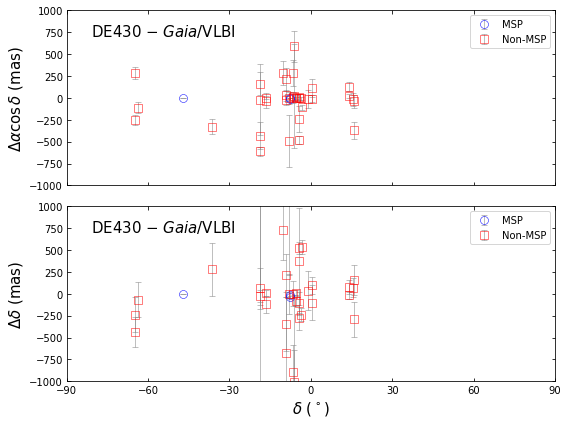

In [46]:
pos_oft_vs_coord(gv_timing430, [-1000, 1000, -1000, 1000],
                 gv_timing430["dra"],
                 gv_timing430["ddec"],
                 add_text=[0.05, 0.85, "DE430 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

## 2.5 DE436 vs Gaia EDR3

In [47]:
mask = gv_timing["eph"] == "DE436"
gv_timing436 = gv_timing[mask]

nb_psr_436 = len(gv_timing436.group_by("psr_name").groups)
nb_obs_436 = len(gv_timing436)

# count_psr_nb(gv_timing436)
print("We have", nb_psr_436,
      "pulsars in the sample from DE436 vs. Gaia DR3 comparison with",
      nb_obs_436, "observations.")

We have 7 pulsars in the sample from DE436 vs. Gaia DR3 comparison with 16 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


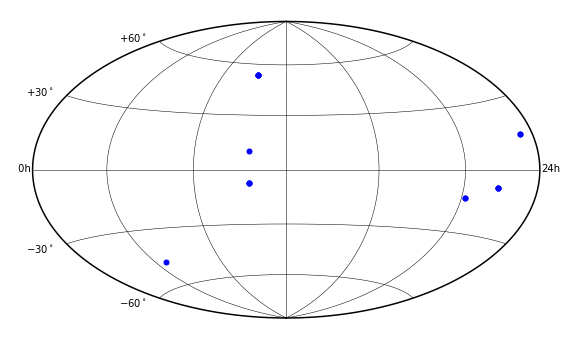

In [48]:
sou_dist_plot(
    gv_timing436["ra_g"],
    gv_timing436["dec_g"],
)

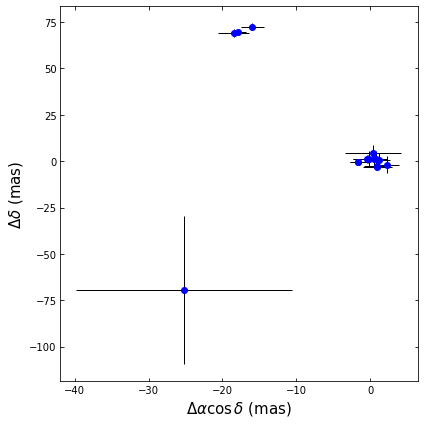

In [49]:
simple_plot(gv_timing436)

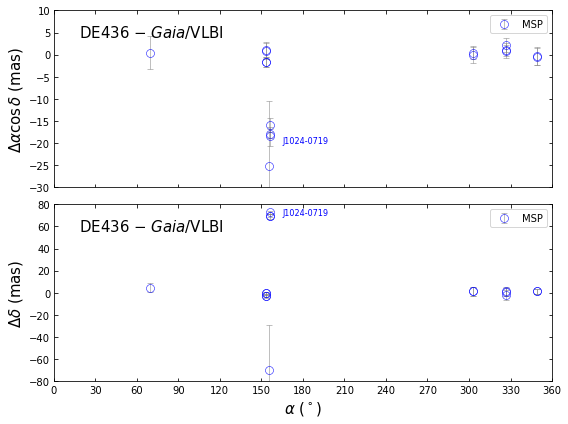

In [50]:
pos_oft_vs_coord(gv_timing436, [-30, 10, -80, 80],
                 gv_timing436["dra"],
                 gv_timing436["ddec"],
                 add_text=[0.05, 0.85, "DE436 $-$ $Gaia$/VLBI"],
                 add_text_msp=[
    [165, -20, "J1024-0719", 0],
    [165, 70, "J1024-0719", 1]],
    ref="g",
    xaxis="ra",
    divided=True)

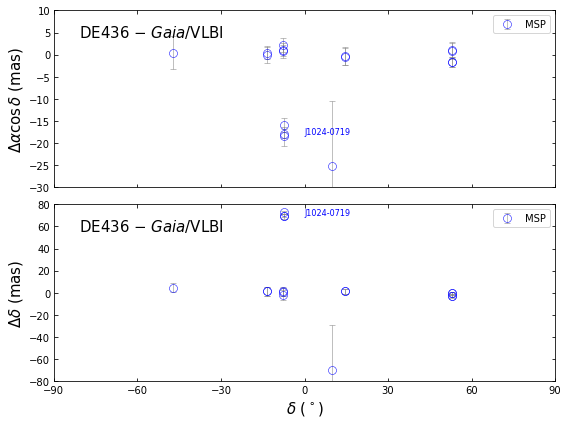

In [51]:
pos_oft_vs_coord(gv_timing436, [-30, 10, -80, 80],
                 gv_timing436["dra"],
                 gv_timing436["ddec"],
                 add_text=[0.05, 0.85, "DE436 $-$ $Gaia$/VLBI"],
                 add_text_msp=[
    [0, -18, "J1024-0719", 0],
    [0, 70, "J1024-0719", 1]],
    ref="g",
    xaxis="dec",
    divided=True)

# 3 Compare timing and Gaia/VLBI reference frames

## 3.1 Remove pulsars near the ecliptic plane

Remove PSRs near the Ecliptic plane within 10 degrees.

In [52]:
mask = (
    (gv_timing["psr_name"] != "J0614+2229")
    & (gv_timing["psr_name"] != "J0534+2200")
    & (gv_timing["psr_name"] != "J0337+1715")
    & (gv_timing["psr_name"] != "J2339-0533")
    #     & (gv_timing["psr_name"] != "J1723-2837")
    #     & (gv_timing["psr_name"] != "J2129-0429")
    #     & (gv_timing["psr_name"] != "J1023+0038")
    & (gv_timing["psr_name"] != "J0614+2229")
    & (gv_timing["psr_name"] != "J0629+2415")
    #     & (gv_timing["psr_name"] != "J0826+2637")
    & (gv_timing["psr_name"] != "J1022+1001")
    & (gv_timing["psr_name"] != "J1257-1027")
    #     & (gv_timing["psr_name"] != "J1650-1654")
    & (gv_timing["psr_name"] != "J1703-1846")
    #     & (gv_timing["psr_name"] != "J2010-1323")
    #     & (gv_timing["psr_name"] != "J2145-0750")
    #     & (gv_timing["psr_name"] != "J2248-0101")
    & (gv_timing["psr_name"] != "J2346-0609")
)
gv_timing = Table(gv_timing[mask], masked=False)

In [53]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

mask = gv_timing["eph"] == "DE436"
gv_timing436 = gv_timing[mask]

In [54]:
nb_psr_200 = len(gv_timing200.group_by("psr_name").groups)
nb_obs_200 = len(gv_timing200)

nb_psr_405 = len(gv_timing405.group_by("psr_name").groups)
nb_obs_405 = len(gv_timing405)

nb_psr_421 = len(gv_timing421.group_by("psr_name").groups)
nb_obs_421 = len(gv_timing421)

nb_psr_430 = len(gv_timing430.group_by("psr_name").groups)
nb_obs_430 = len(gv_timing430)

nb_psr_436 = len(gv_timing436.group_by("psr_name").groups)
nb_obs_436 = len(gv_timing436)

## 3.2 DE200 vs. Gaia + VLBI

Do the LSQ fitting iterately.

In [55]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    gv_timing200)

rot200, iqr200 = find_pmt_est(pmt200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 66 1266536.5 1266529.9       5.83     -13.35     -17.97 J0323+3944    48382 324011021.0
 2 66    876.3    868.4       9.47     -17.13     -18.16 J0857-4424    49080 216517.1
 3 65     18.3     14.8      -0.44     -12.50     -12.11 J0826+2637    51700   2673.3
 4 65      7.8      4.2      -1.06     -12.80     -12.23 J1537+1155    50300      0.1
 5 65      6.8      4.3      -1.06     -12.77     -12.15 J1537+1155    50261      0.2
 6 65      5.7      4.3      -1.25     -12.57     -11.91 J1537+1155    48778      1.0
 7 65      4.8      4.3      -2.84     -11.43     -11.33 J1901-0906    49901    120.9
 8 65      4.4      3.9      -2.85     -11.40     -11.21 J1820-0427    51700    114.9
 9 65      4.0      3.4      -2.47     -11.50     -11.57 J2113+4644    51700     87.8
10 65      3.6      3.1      -2.11     -11.70     -11.84 J1024-0719    50456     87.0
11 65      3.3      2.7      -3.81     -13.95    

99 29      0.2      0.1      -4.25      12.41      -0.00 J2248-0101    50866      0.6
100 28      0.2      0.1      -4.39      12.00      -0.16 J1820-0427    46918      0.6
101 27      0.1      0.1      -4.47      11.97      -0.28 J1532+2745    49666      0.4
102 26      0.1      0.1      -3.84      10.34      -0.51 J1919+0021    49427      0.6
103 25      0.1      0.1      -3.98       9.88      -1.02 J0335+4555    48416      0.6
104 24      0.1      0.1      -1.29      13.81      -1.17 J0826+2637    46450      0.4
105 23      0.1      0.1       1.87      16.30      -0.57 J1754+5201    49666      0.4
106 22      0.1      0.1       1.79      15.13      -0.71 J1901-0906    49619      0.5
107 22      0.1      0.1       2.93      15.77      -0.47 J0152-1637    48227      0.2
108 21      0.1      0.1       0.76      10.92      -1.94 J1607-0032    48419      0.4
109 21      0.1      0.1       1.40      10.95      -1.32 J1650-1654    50862      0.4
110 20      0.1      0.1       1.44      11.

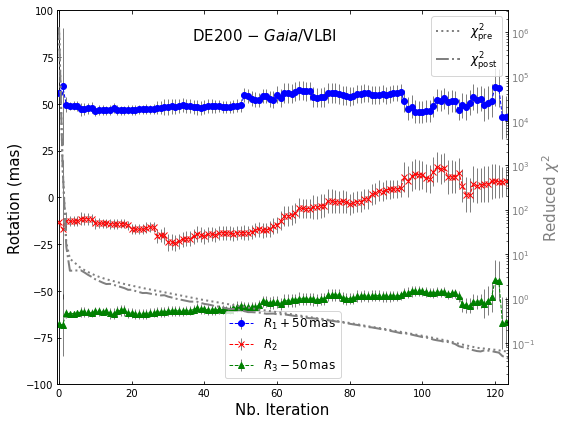

In [56]:
rot_vs_iter(pmt200,
            sig200, [-0.5, 123.5, -100, 100],
            elw=0.5,
            add_text=[0.3, 0.92, "DE200 $-$ $Gaia$/VLBI"],
            apr_chi2=apr_chi2_200,
            pst_chi2=pst_chi2_200,
            ax_loc="lower center",
            ax1_loc="upper right",
            y_shift=50, caps=0)

When removing these two PSRs, 

In [57]:
mask = ((np.fabs(gv_timing200["dra"]) < 1000)
        & (np.fabs(gv_timing200["ddec"]) < 1000)
        )

gv_timing200_a = gv_timing200[mask]

In [58]:
nb_psr_200 = len(gv_timing200_a.group_by("psr_name").groups)
nb_obs_200 = len(gv_timing200_a)

print("After removing outliers, we have", nb_psr_200,
      "pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_200, "observations.")

After removing outliers, we have 65 pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with 120 observations.


and I do the LSQ fitting again.

In [59]:
pmt200_a, sig200_a, indx_a, apr_chi2_200_a, pst_chi2_200_a = rot_fit_4_table(
    gv_timing200_a)

rot200_a, iqr200_a = find_pmt_est(pmt200_a)

dra_200, ddec_200 = calc_dpos(gv_timing200, rot200_a)

a_chi2_200, p_chi2_200 = calc_chi2_4_fit(gv_timing200, dra_200, ddec_200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 65      7.5      3.7      -1.02     -12.78     -12.22 J1537+1155    50300      0.1
 2 65      6.3      3.7      -1.01     -12.75     -12.13 J1537+1155    50261      0.2
 3 65      5.2      3.7      -1.19     -12.55     -11.88 J1537+1155    48778      0.9
 4 65      4.3      3.8      -2.78     -11.39     -11.24 J1820-0427    51700    114.9
 5 65      3.8      3.3      -2.40     -11.49     -11.60 J2113+4644    51700     87.8
 6 65      3.5      2.9      -2.04     -11.69     -11.88 J1024-0719    50456     86.8
 7 65      3.2      2.5      -3.73     -13.94     -10.99 J1321+8323    48383     58.5
 8 65      2.9      2.3      -3.43     -13.86     -11.06 J2145-0750    48979     42.2
 9 65      2.8      2.1      -3.47     -13.79     -10.91 J2145-0750    50317      0.4
10 65      2.6      2.1      -3.15     -14.33     -12.02 J1321+8323    48889     26.2
11 64      2.5      2.0      -2.16     -14.11     -12.

97 21      0.1      0.1       1.84      15.23      -0.74 J1901-0906    49619      0.5
98 21      0.1      0.1       2.97      15.88      -0.51 J0152-1637    48227      0.2
99 20      0.1      0.1       0.80      11.05      -1.97 J1607-0032    48419      0.4
100 20      0.1      0.1       1.44      11.08      -1.36 J1645-0317    49028      0.5
101 19      0.1      0.1      -3.27      13.18      -3.03 J1607-0032    46973      0.2
102 18      0.1      0.1      -0.86       6.29      -7.30 J2354+6155    49028      0.2
103 17      0.1      0.1      -1.46       1.46      -7.82 J2113+4644    46614      0.3
104 16      0.1      0.1       0.59       1.12      -7.91 J1937+2544    48415      0.2
105 15      0.1      0.1       3.53       7.10      -5.72 J2325+6316    48309      0.2
106 14      0.1      0.1       2.15       6.33      -5.89 J2006-0807    49766      0.2
107 13      0.1      0.1       2.76       6.55      -5.29 J1735-0724    49887      0.0
108 12      0.1      0.1      -0.43       7.16

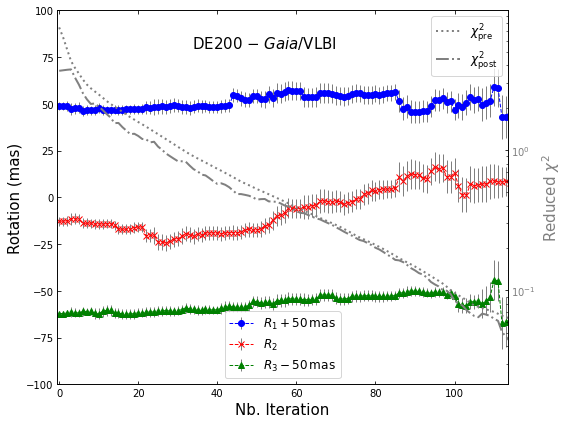

In [60]:
rot_vs_iter(
    pmt200_a,
    sig200_a,
    [-0.5, 113.5, -100, 100],
    elw=0.5,
    add_text=[0.3, 0.9, "DE200 $-$ $Gaia$/VLBI"],
    apr_chi2=apr_chi2_200_a,
    pst_chi2=pst_chi2_200_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=50, caps=0
)

In [61]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200[0], iqr200[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200[1], iqr200[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200[2], iqr200[2]))

print("After removing J0857-4424, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[0], iqr200_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[1], iqr200_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[2], iqr200_a[2]))

Using all samples, the rotation parameters are
R1:      -0 +/-      5 mas
R2:     -10 +/-      6 mas
R3:      -7 +/-      6 mas
After removing J0857-4424, the rotation parameters are
R1:      -1 +/-      5 mas
R2:      -8 +/-      6 mas
R3:      -7 +/-      6 mas


## 3.3 DE405 vs Gaia+VLBI

In [62]:
pmt405, sig405, indx, apr_chi2_405, pst_chi2_405 = rot_fit_4_table(
    gv_timing405)

rot405, iqr405 = find_pmt_est(pmt405)

dra_405, ddec_405 = calc_dpos(gv_timing405, rot405)

a_chi2_405, p_chi2_405 = calc_chi2_4_fit(gv_timing405, dra_405, ddec_405)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 20     24.3     23.0      10.95       6.19      -2.79 J2032+4127    54938    293.9
 2 19     18.2     16.8      11.50       5.86      -3.14 J1024-0719    53000    192.6
 3 19     12.1     11.9       5.48      -0.10      -1.22 J1024-0719    53000    242.6
 4 18      5.5      4.8      -2.30      -7.61       1.36 J2027+4557    54250     96.7
 5 17      2.8      2.2      -2.94      -6.63       2.09 J1227-4853    56708     37.9
 6 16      0.9      0.8      -1.70      -0.98       1.93 J1723-2837    55667     14.1
 7 15      0.5      0.4      -1.13      -0.71       1.43 J1136+1551    52398      3.2
 8 14      0.4      0.3      -1.13      -0.73       1.43 J1012+5307    50700      1.9
 9 14      0.3      0.3      -0.80       0.44       1.43 J0826+2637    52398      1.9
10 13      0.3      0.2      -0.82       0.43       1.44 J2145-0750    53040      0.2
11 13      0.2      0.2       0.26       0.14      -0.

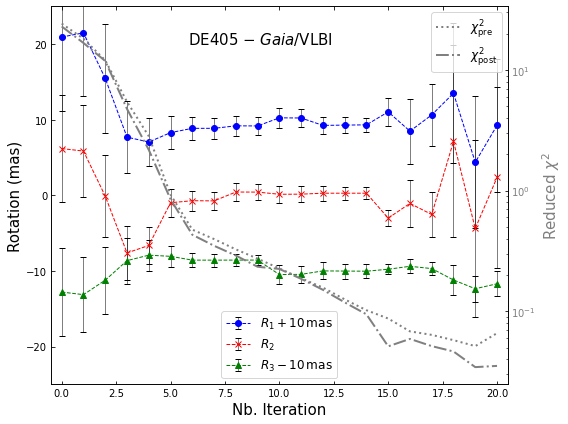

In [63]:
rot_vs_iter(
    pmt405,
    sig405,
    [-0.5, 20.5, -25, 25],
    add_text=[0.3, 0.9, "DE405 $-$ $Gaia$/VLBI"],
    apr_chi2=apr_chi2_405,
    pst_chi2=pst_chi2_405,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=10
)

Let me try to remove some PSRs.

In [64]:
mask = (
    (np.fabs(gv_timing405["dra"]) < 1000)
    & (np.fabs(gv_timing405["ddec"]) < 1000)
)


gv_timing405_a = gv_timing405[mask]

In [65]:
nb_psr_405 = len(gv_timing405_a.group_by("psr_name").groups)
nb_obs_405 = len(gv_timing405_a)

print("After removing outliers, we have", nb_psr_405,
      "pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_405, "observations.")

After removing outliers, we have 19 pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with 22 observations.


In [66]:
pmt405_a, sig405_a, indx, apr_chi2_405_a, pst_chi2_405_a = rot_fit_4_table(
    gv_timing405_a)

rot405_a, iqr405_a = find_pmt_est(pmt405_a)

dra_405_a, ddec_405_a = calc_dpos(gv_timing405_a, rot405_a)

a_chi2_405_a, p_chi2_405_a = calc_chi2_4_fit(
    gv_timing405_a, dra_405_a, ddec_405_a)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 19     18.2     16.8      11.50       5.86      -3.14 J1024-0719    53000    192.6
 2 19     12.1     11.9       5.48      -0.10      -1.22 J1024-0719    53000    242.6
 3 18      5.5      4.8      -2.30      -7.61       1.36 J2027+4557    54250     96.7
 4 17      2.8      2.2      -2.94      -6.63       2.09 J1227-4853    56708     37.9
 5 16      0.9      0.8      -1.70      -0.98       1.93 J1723-2837    55667     14.1
 6 15      0.5      0.4      -1.13      -0.71       1.43 J1136+1551    52398      3.2
 7 14      0.4      0.3      -1.13      -0.73       1.43 J1012+5307    50700      1.9
 8 14      0.3      0.3      -0.80       0.44       1.43 J0826+2637    52398      1.9
 9 13      0.3      0.2      -0.82       0.43       1.44 J2145-0750    53040      0.2
10 13      0.2      0.2       0.26       0.14      -0.48 J1958+2846    54800      1.2
11 12      0.2      0.2       0.24       0.16      -0.

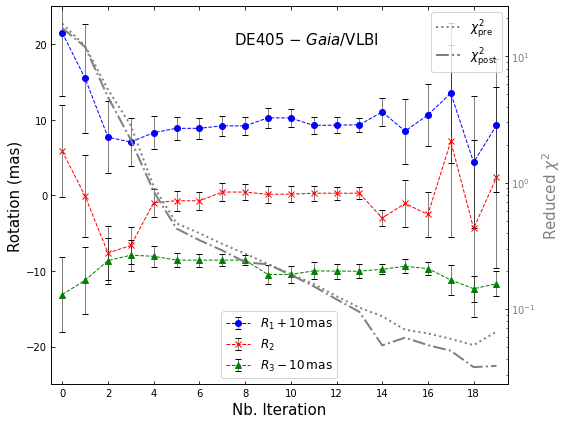

In [67]:
rot_vs_iter(
    pmt405_a,
    sig405_a,
    [-0.5, 19.5, -25, 25],
    add_text=[0.4, 0.9, "DE405 $-$ $Gaia$/VLBI"],
    xaxis_range=np.arange(0, 20, 2),
    apr_chi2=apr_chi2_405_a,
    pst_chi2=pst_chi2_405_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=10
)

In [68]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot405[0], iqr405[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot405[1], iqr405[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot405[2], iqr405[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot405_a[0], iqr405_a[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot405_a[1], iqr405_a[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot405_a[2], iqr405_a[2]))

Using all samples, the rotation parameters are
R1:  -0.745 +/-  1.317 mas
R2:   0.144 +/-  1.943 mas
R3:   0.004 +/-  1.943 mas
After removing outliers, the rotation parameters are
R1:  -0.746 +/-  1.171 mas
R2:   0.021 +/-  1.546 mas
R3:   0.113 +/-  1.546 mas


## 3.4 DE421 vs Gaia

In [69]:
pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(
    gv_timing421)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 31    425.8    377.0      -5.56      14.90      18.28 J1928+1245    57974  27420.8
 2 30     54.4     47.4       6.07       8.47      -3.27 J1024-0719    55800   1469.7
 3 30     33.4     31.3       3.76       4.65      -1.93 J1024-0719    55000    786.4
 4 30     23.7     22.9       2.55       2.69      -1.22 J1024-0719    55000    844.3
 5 30     13.6     13.5       1.26       0.58      -0.44 J1024-0719    54500    624.6
 6 29      6.4      6.3       0.31      -0.95       0.13 J1645-0317    56000    278.7
 7 28      3.2      3.1       0.19      -0.91       0.14 J0729-1836    56000     76.8
 8 27      2.3      2.3       0.22      -0.91       0.12 J1302-6350    55000     29.7
 9 26      2.0      2.0      -0.05      -0.86       0.23 J1048+2339    56700     23.0
10 25      1.7      1.7      -0.04      -0.41      -0.07 J2149+6329    54595     25.2
11 24      1.4      1.4       0.07      -0.47      -0.

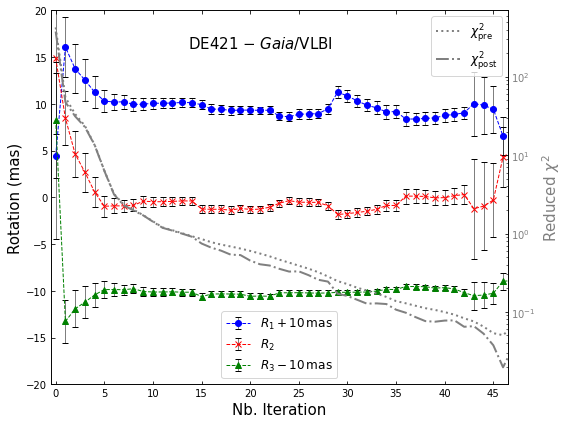

In [70]:
rot_vs_iter(
    pmt421,
    sig421,
    [-0.5, 46.5, -20, 20],
    xaxis_range=np.arange(0, 46, 5),
    add_text=[0.3, 0.9, "DE421 $-$ $Gaia$/VLBI"],
    apr_chi2=apr_chi2_421,
    pst_chi2=pst_chi2_421,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=10
)

In [71]:
rot421, iqr421 = find_pmt_est(pmt421)

dra_421, ddec_421 = calc_dpos(gv_timing421, rot421)

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(gv_timing421, dra_421, ddec_421)

In [72]:
mask = (
    (np.fabs(gv_timing421["dra"]) < 1000)
    & (np.fabs(gv_timing421["ddec"]) < 1000)
)


gv_timing421_a = gv_timing421[mask]

In [73]:
pmt421_a, sig421_a, indx, apr_chi2_421_a, pst_chi2_421_a = rot_fit_4_table(
    gv_timing421_a)

rot421_a, iqr421_a = find_pmt_est(pmt421_a)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 31    434.7    384.8      -5.57      14.90      18.28 J1928+1245    57974  27420.2
 2 30     55.4     48.2       6.07       8.46      -3.27 J1024-0719    55800   1469.8
 3 30     33.9     31.7       3.75       4.65      -1.92 J1024-0719    55000    786.5
 4 30     24.0     23.2       2.55       2.69      -1.21 J1024-0719    55000    844.4
 5 30     13.6     13.5       1.25       0.58      -0.44 J1024-0719    54500    624.7
 6 29      6.3      6.2       0.30      -0.96       0.13 J1645-0317    56000    278.7
 7 28      3.0      3.0       0.19      -0.91       0.14 J0729-1836    56000     76.8
 8 27      2.1      2.1       0.22      -0.91       0.12 J1302-6350    55000     29.7
 9 26      1.8      1.8      -0.06      -0.86       0.23 J1048+2339    56700     23.0
10 25      1.5      1.5      -0.04      -0.41      -0.07 J2149+6329    54595     25.2
11 24      1.2      1.2       0.07      -0.47      -0.

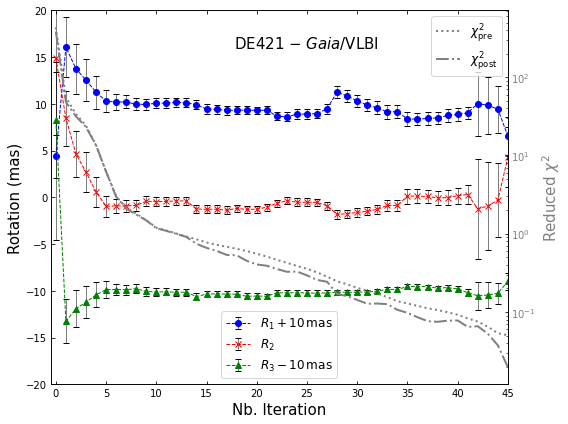

In [74]:
rot_vs_iter(
    pmt421_a,
    sig421_a,
    [-0.5, 19.5, -20, 20],
    add_text=[0.4, 0.9, "DE421 $-$ $Gaia$/VLBI"],
    xaxis_range=np.arange(0, 46, 5),
    apr_chi2=apr_chi2_421_a,
    pst_chi2=pst_chi2_421_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=10
)

In [75]:
dra_421, ddec_421 = calc_dpos(gv_timing421, rot421_a)

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(gv_timing421, dra_421, ddec_421)

In [76]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot421[0], iqr421[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot421[1], iqr421[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot421[2], iqr421[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot421_a[0], iqr421_a[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot421_a[1], iqr421_a[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot421_a[2], iqr421_a[2]))

Using all samples, the rotation parameters are
R1:  -0.560 +/-  0.882 mas
R2:  -0.534 +/-  0.356 mas
R3:  -0.154 +/-  0.356 mas
After removing outliers, the rotation parameters are
R1:  -0.565 +/-  0.893 mas
R2:  -0.543 +/-  0.360 mas
R3:  -0.155 +/-  0.360 mas


## 3.5 DE430 vs Gaia

In [77]:
pmt430, sig430, indx, apr_chi2_430, pst_chi2_430 = rot_fit_4_table(
    gv_timing430)

rot430, iqr430 = find_pmt_est(pmt430)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 22     14.0     13.8       1.98       6.64      -8.69 J1833-0338    57600    389.3
 2 22      8.4      8.1       2.28       7.45      -9.63 J0729-1836    57600    125.0
 3 22      6.6      6.4       1.92       6.57      -8.56 J1820-0427    57600    121.3
 4 22      4.7      4.6       1.27       4.87      -6.58 J1645-0317    57600     55.4
 5 21      3.9      3.8       1.02       4.12      -5.72 J1820-0427    57600     56.3
 6 20      3.0      2.9       1.22       4.54      -6.19 J1305-6455    57600     24.7
 7 20      2.7      2.5       1.41       4.98      -6.69 J1305-6455    57600     22.3
 8 19      2.4      2.2       1.19       4.50      -6.14 J2145-0750    57600     17.6
 9 19      2.0      2.0       1.21       4.74      -6.69 J1136+1551    57600     15.9
10 19      1.8      1.7       0.88       3.85      -5.65 J1817-3618    57600     14.2
11 18      1.6      1.5       0.22       2.10      -3.

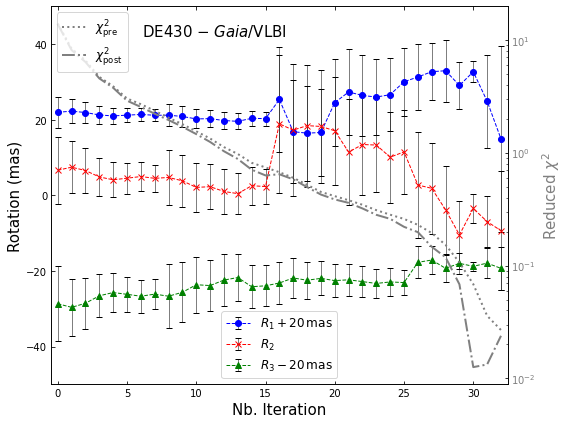

In [78]:
rot_vs_iter(
    pmt430,
    sig430,
    [-0.5, 32.5, -50, 50],
    apr_chi2=apr_chi2_430,
    pst_chi2=pst_chi2_430,
    add_text=[0.2, 0.92, "DE430 $-$ $Gaia$/VLBI"],
    xaxis_range=np.arange(0, 31, 5),
    ax_loc="lower center",
    ax1_loc="upper left",
    elw=0.5,
    y_shift=20,

)

In [79]:
mask = (
    (np.fabs(gv_timing430["dra"]) < 1000)
    & (np.fabs(gv_timing430["ddec"]) < 1000)
)


gv_timing430_a = gv_timing430[mask]

In [80]:
pmt430_a, sig430_a, indx, apr_chi2_430_a, pst_chi2_430_a = rot_fit_4_table(
    gv_timing430_a)

rot430_a, iqr430_a = find_pmt_est(pmt430_a)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 22      8.6      8.3       2.27       7.42      -9.60 J0729-1836    57600    125.0
 2 22      6.7      6.5       1.91       6.54      -8.52 J1820-0427    57600    121.3
 3 22      4.8      4.7       1.26       4.84      -6.54 J1645-0317    57600     55.4
 4 21      3.9      3.8       1.01       4.09      -5.68 J1820-0427    57600     56.3
 5 20      3.1      2.9       1.21       4.50      -6.15 J1305-6455    57600     24.7
 6 20      2.7      2.6       1.40       4.95      -6.65 J1305-6455    57600     22.3
 7 19      2.4      2.2       1.18       4.47      -6.10 J2145-0750    57600     17.6
 8 19      2.0      1.9       1.15       4.57      -6.50 J1136+1551    57600     15.9
 9 19      1.8      1.7       0.81       3.68      -5.46 J1817-3618    57600     14.2
10 18      1.5      1.4       0.16       1.94      -3.46 J0151-0635    57600     12.5
11 18      1.3      1.2       0.24       2.12      -3.

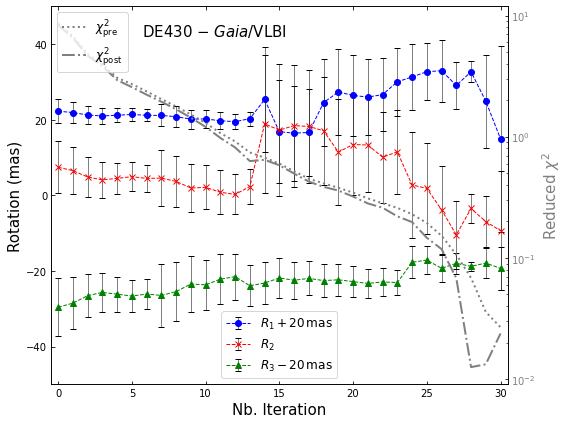

In [81]:
rot_vs_iter(
    pmt430_a,
    sig430_a,
    [-0.5, 30.5, -50, 50],
    apr_chi2=apr_chi2_430_a,
    pst_chi2=pst_chi2_430_a,
    add_text=[0.2, 0.92, "DE430 $-$ $Gaia$/VLBI"],
    xaxis_range=np.arange(0, 31, 5),
    ax_loc="lower center",
    ax1_loc="upper left",
    elw=0.5,
    y_shift=20
)

In [82]:
dra_430, ddec_430 = calc_dpos(gv_timing430, rot430_a)

a_chi2_430, p_chi2_430 = calc_chi2_4_fit(gv_timing430, dra_430, ddec_430)

In [83]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot430[0], iqr430[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot430[1], iqr430[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot430[2], iqr430[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot430_a[0], iqr430_a[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot430_a[1], iqr430_a[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot430_a[2], iqr430_a[2]))

Using all samples, the rotation parameters are
R1:   1.408 +/-  4.545 mas
R2:   4.535 +/-  2.857 mas
R3:  -3.082 +/-  2.857 mas
After removing outliers, the rotation parameters are
R1:   1.396 +/-  4.648 mas
R2:   4.503 +/-  2.877 mas
R3:  -2.913 +/-  2.877 mas


## 3.6 DE436 vs Gaia

In [84]:
pmt436, sig436, indx, apr_chi2_436, pst_chi2_436 = rot_fit_4_table(
    gv_timing436)

rot436, iqr436 = find_pmt_est(pmt436)

dra_436, ddec_436 = calc_dpos(gv_timing436, rot436)

a_chi2_436, p_chi2_436 = calc_chi2_4_fit(gv_timing436, dra_436, ddec_436)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  6    255.8    176.0      13.89      18.62      -5.77 J1024-0719    56239   1732.8
 2  6    117.3    100.5       6.45       9.39      -2.71 J1024-0719    55636   1321.5
 3  6     43.7     42.0       1.73       3.09      -0.97 J1024-0719    55000    850.2
 4  5      0.8      0.5      -1.54      -0.68       0.51 J1012+5307    55000      1.7
 5  5      0.7      0.5      -1.62      -0.34       0.52 J1012+5307    55291      1.8
 6  5      0.6      0.4      -1.78       0.13       0.54 J1012+5307    55291      0.4
 7  5      0.5      0.4      -1.26      -0.24       0.52 J1012+5307    55000      1.0
 8  4      0.4      0.2       1.90      -1.74       0.46 J2145-0750    55322      1.1
 9  4      0.3      0.1       1.50      -1.79       0.21 J0437-4715    55000      0.5
10  3      0.3      0.1       0.48      -1.51       0.25 J2145-0750    55657      0.2
11  3      0.2      0.1       0.19      -1.48       0.

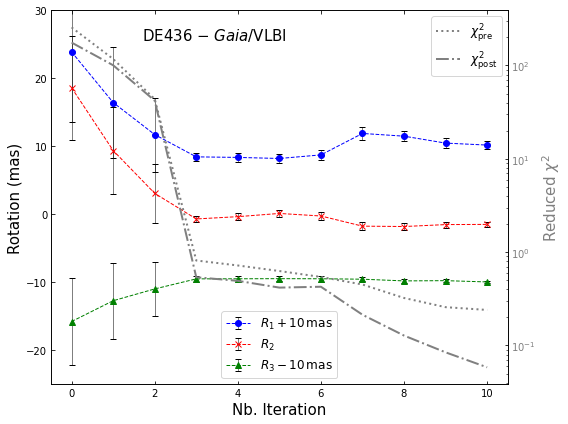

In [85]:
rot_vs_iter(
    pmt436,
    sig436,
    [-0.5, 10.5, -25, 30],
    apr_chi2=apr_chi2_436,
    pst_chi2=pst_chi2_436,
    #     xaxis_range=np.arange(0, 5, 31),
    add_text=[0.2, 0.92, "DE436 $-$ $Gaia$/VLBI"],
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=10
)

In [86]:
mask = (gv_timing436["psr_name"] != "J1024-0719")

gv_timing436_a = gv_timing436[mask]

In [87]:
pmt436_a, sig436_a, indx_a, apr_chi2_436_a, pst_chi2_436_a = rot_fit_4_table(
    gv_timing436_a)

rot436_a, iqr436_a = find_pmt_est(pmt436_a)

print(rot436_a, iqr436_a)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  5      0.8      0.5      -1.54      -0.68       0.51 J1012+5307    55000      1.7
 2  5      0.7      0.5      -1.62      -0.34       0.52 J1012+5307    55291      1.8
 3  5      0.6      0.4      -1.78       0.13       0.54 J1012+5307    55291      0.4
 4  5      0.5      0.4      -1.26      -0.24       0.52 J1012+5307    55000      1.0
 5  4      0.4      0.2       1.90      -1.74       0.46 J2145-0750    55322      1.1
 6  4      0.3      0.1       1.50      -1.79       0.21 J0437-4715    55000      0.5
 7  3      0.3      0.1       0.48      -1.51       0.25 J2145-0750    55657      0.2
 8  3      0.2      0.1       0.19      -1.48       0.06 J2145-0750    55000      0.2
[-0.53268008 -1.07757888  0.48450127] [1.70247523 0.92510705 0.21112878]


# 4 Summarize the results

The comparison of formal uncertainties of pulsar positions.

In [88]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t",
             "RA_err_g", "dec_err_g", "pos_err_t"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and Gaia positions (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"],
)

print(tbl)

Positional formal uncertainty for timing and Gaia positions (mas)
      RA_err_t dec_err_t pos_err_t RA_err_g dec_err_g pos_err_t
---------------------------------------------------------------
DE200    58.59    125.00    146.61     1.40      1.00      1.74
DE405    50.91     90.00    126.41     0.85      1.00      1.30
DE421     1.38      3.00      4.23     1.03      1.00      1.43
DE430    69.40    200.00    207.13     1.49      2.00      2.49
DE436     0.08      0.19      0.21     1.18      1.00      1.55
---------------------------------------------------------------


A short table to summarize the orientation between DE frame and Gaia frame.

In [89]:
mydata = [
    [
        nb_psr_200,
        nb_obs_200,
        rot200_a[0],
        iqr200_a[0],
        rot200_a[1],
        iqr200_a[1],
        rot200_a[2],
        iqr200_a[2],
        a_chi2_200,
        p_chi2_200,
    ],
    [
        nb_psr_405,
        nb_obs_405,
        rot405_a[0],
        iqr405_a[0],
        rot405_a[1],
        iqr405_a[1],
        rot405_a[2],
        iqr405_a[2],
        a_chi2_405,
        p_chi2_405,
    ],
    [
        nb_psr_421,
        nb_obs_421,
        rot421_a[0],
        iqr421_a[0],
        rot421_a[1],
        iqr421_a[1],
        rot421_a[2],
        iqr421_a[2],
        a_chi2_421,
        p_chi2_421,
    ],
    [
        nb_psr_430,
        nb_obs_430,
        rot430_a[0],
        iqr430_a[0],
        rot430_a[1],
        iqr430_a[1],
        rot430_a[2],
        iqr430_a[2],
        a_chi2_430,
        p_chi2_430,
    ],
    [
        nb_psr_436,
        nb_obs_436,
        rot436[0],
        iqr436[0],
        rot436[1],
        iqr436[1],
        rot436[2],
        iqr436[2],
        a_chi2_436,
        p_chi2_436,
    ],
]

myheaders = [
    "Nb.PSR",
    "Nb.Obs",
    "R1",
    "R1_err",
    "R2",
    "R2_err",
    "R3",
    "R3_err",
    "ApreFitChi2",
    "PostFitChi2",
]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. Gaia frame (mas)",
    data_fmts=[
        "%d",
        "%d",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.2f",
        "%6.2f",
    ],
)

print(tbl)

                    Orientation of DE frame wrt. Gaia frame (mas)                    
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200     65    120   -0.6    5.0   -7.6   15.9   -6.9    5.8  1251866.17  1251861.94
DE405     19     22   -0.7    1.2    0.0    1.3    0.1    1.5       22.65       22.72
DE421     31     50   -0.6    0.9   -0.5    0.9   -0.2    0.4      412.93      414.58
DE430     22     35    1.4    4.6    4.5    7.1   -2.9    2.9       13.38       13.49
DE436      6     15    0.5    2.4   -0.3    2.3    0.2    0.7      229.37      230.46
-------------------------------------------------------------------------------------
